<h2>Finding Ghosts</h2>
<h2>Traccar 테스트 데이터 분석 - 데이터 수집량을 중심으로</h2>
<p>In theory, our tester's Traccar clients are supposed to send position data at every minutes. In fact, there is a delay of few seconds, practically. This is acceptable. However, we found that some clients didn't send data about a 3-6 hours.</p>
<p>We have to figure out why.</p>
<p>일부 환경에서 Traccar 가 오랜 기간 (몇 시간) 동안 데이터를 송신하지 않는 현상을 확인해야 한다.
주로 아이폰에서 일어나는 것으로 파악.</p>

<h5>Client Info</h5>
<p>Date: 201901<br>
Traccar Server: v4.2<br>
Freq.: 60 sec.<br>
    </p>
<table>
    <thead>
        <tr>
            <th>Name</th>
            <th>Phone</th>
            <th>OS</th>
            <th>Traccar Client</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>DBLAB0101</td>
            <td>V20</td>
            <td>8.0.0/F800K20i</td>
            <td>5.17</td>            
        </tr>
        <tr>
            <td>DBLAB0102</td>
            <td>S5</td>
            <td>6.0.1/F800K20i</td>
            <td>5.17</td>            
        </tr>
        <tr>
            <td>DBLAB0103</td>
            <td>iPhone 6</td>
            <td>12.1.2/16C104</td>
            <td>5.5</td>            
        </tr>
        <tr>
            <td>DBLAB0201</td>
            <td>iPhone XS</td>
            <td>12.1.2</td>
            <td>5.5</td>            
        </tr>
        <tr>
            <td>DBLAB0301</td>
            <td>iPhone X</td>
            <td>12.1.3 beta 4</td>
            <td>5.5</td>            
        </tr>
        <tr>
            <td>HCICG01</td>
            <td>?</td>
            <td>?</td>
            <td>?</td>            
        </tr>
    </tbody>
</table>

<p>어쩌다 알아내게 된 것: Traccar 클라이언트가 신호를 올바르게 보내지만 서버에 등록되어있지 않았던 경우 다시 등록하면 한방에 다 보낸다...</p>
<p>HCICG0160 실험자 자료 (1월 9일 종료)</p>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.io.json import json_normalize #package for flattening json in pandas df
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL
import json
import copy
from datetime import timedelta, date, timedelta
from pprint import pprint

<h3>Connecting Database</h3>
<p>Database configuration file is only for our researchers. <br>
    If you are CSSC member and need to raw data, contact our lab (DBLab) students.
    </p>

In [2]:
dbconfig = json.loads(open("res/dbconfig.properties").read())
engine = create_engine(URL(**dbconfig["cssc_jaunt"]))

In [3]:
sql = "select id, name, lastupdate from tc_devices;"
users = pd.read_sql_query(sql, engine)

In [4]:
users

,id,name,lastupdate
0,54,HCICG01,2019-01-26 15:22:31.965
1,52,DBLAB0103,2019-01-26 15:34:14.203
2,51,DBLAB0102,2019-01-26 03:05:05.957
3,50,DBLAB0201,2019-01-25 17:37:59.779
4,48,DBLAB0301,2019-01-18 09:47:04.167
5,49,DBLAB0101,2019-01-20 17:54:21.261


Testers may pause sending their location if they need to be more private.

In [5]:
pos_query = "select d.name, p.* from tc_positions p, tc_devices d where p.deviceid = d.id and d.id IN (select id from tc_devices where name=ANY({$users}))"
users_str = users['name'].to_json(force_ascii=False, orient='values')
users_str

'["HCICG01","DBLAB0103","DBLAB0102","DBLAB0201","DBLAB0301","DBLAB0101"]'

In [6]:
#pgsql array style string : { ... }
users_str = list(users_str)
users_str[0] = '{'
users_str[-1] = '}'
users_str = "".join(users_str)
users_str

'{"HCICG01","DBLAB0103","DBLAB0102","DBLAB0201","DBLAB0301","DBLAB0101"}'

In [7]:
pos_query = "select d.name, p.* from tc_positions p, tc_devices d where p.deviceid = d.id and d.id IN (select id from tc_devices where name=ANY('{0}'))".format(users_str)
pos_query

'select d.name, p.* from tc_positions p, tc_devices d where p.deviceid = d.id and d.id IN (select id from tc_devices where name=ANY(\'{"HCICG01","DBLAB0103","DBLAB0102","DBLAB0201","DBLAB0301","DBLAB0101"}\'))'

In [8]:
#pos_query += "LIMIT 10"
traccar = pd.read_sql_query(pos_query, engine)

In [9]:
traccar.head()

,name,id,protocol,deviceid,servertime,devicetime,fixtime,valid,latitude,longitude,altitude,speed,course,address,attributes,accuracy,network
0,DBLAB0301,286386,osmand,48,2019-01-16 14:49:08.835,2019-01-16 14:49:06,2019-01-16 14:49:06,True,37.555166,127.050135,26.661201,0.0,0.0,None,"{""batteryLevel"":74.0,""distance"":0.0,""totalDist...",0.0,null
1,DBLAB0301,286387,osmand,48,2019-01-16 14:50:05.620,2019-01-16 14:49:40,2019-01-16 14:49:40,True,37.555168,127.050031,27.668663,0.0,0.0,None,"{""batteryLevel"":74.0,""distance"":9.18,""totalDis...",0.0,null
2,DBLAB0301,286388,osmand,48,2019-01-16 14:50:22.141,2019-01-16 14:50:05,2019-01-16 14:50:05,True,37.555143,127.050146,27.339186,0.0,0.0,None,"{""batteryLevel"":74.0,""distance"":10.52,""totalDi...",0.0,null
3,DBLAB0301,286389,osmand,48,2019-01-16 14:50:31.135,2019-01-16 14:50:28,2019-01-16 14:50:28,True,37.555248,127.050002,27.484837,0.0,0.0,None,"{""batteryLevel"":74.0,""distance"":17.27,""totalDi...",0.0,null
4,DBLAB0301,286390,osmand,48,2019-01-16 14:50:35.049,2019-01-16 14:50:35,2019-01-16 14:50:35,True,37.555233,127.049978,27.477942,0.0,0.0,None,"{""batteryLevel"":74.0,""distance"":2.7,""totalDist...",0.0,null


<h3>Attributes parsing</h3>
<p>'attributes' column has additional comupted attributes data from client in json format. See details <a href="https://www.traccar.org/documentation/computed-attributes/">here</a><br>
It contains battery level, distance of single track, total distance of the device, and motion by default.</p>

In [10]:
json.loads(traccar['attributes'][0])

{'batteryLevel': 74.0, 'distance': 0.0, 'totalDistance': 0.0, 'motion': False}

In [11]:
traccar["battery_level"] = traccar['attributes'].map(lambda x: json.loads(x)['batteryLevel'])
traccar["dist"] = traccar['attributes'].map(lambda x: json.loads(x)['distance'])
traccar["total_dist"] = traccar['attributes'].map(lambda x: json.loads(x)['totalDistance'])
traccar["motion"] = traccar['attributes'].map(lambda x: json.loads(x)['motion'])

In [12]:
traccar.head()

,name,id,protocol,deviceid,servertime,devicetime,fixtime,valid,latitude,longitude,...,speed,course,address,attributes,accuracy,network,battery_level,dist,total_dist,motion
0,DBLAB0301,286386,osmand,48,2019-01-16 14:49:08.835,2019-01-16 14:49:06,2019-01-16 14:49:06,True,37.555166,127.050135,...,0.0,0.0,None,"{""batteryLevel"":74.0,""distance"":0.0,""totalDist...",0.0,null,74.0,0.00,0.00,False
1,DBLAB0301,286387,osmand,48,2019-01-16 14:50:05.620,2019-01-16 14:49:40,2019-01-16 14:49:40,True,37.555168,127.050031,...,0.0,0.0,None,"{""batteryLevel"":74.0,""distance"":9.18,""totalDis...",0.0,null,74.0,9.18,9.18,False
2,DBLAB0301,286388,osmand,48,2019-01-16 14:50:22.141,2019-01-16 14:50:05,2019-01-16 14:50:05,True,37.555143,127.050146,...,0.0,0.0,None,"{""batteryLevel"":74.0,""distance"":10.52,""totalDi...",0.0,null,74.0,10.52,19.70,False
3,DBLAB0301,286389,osmand,48,2019-01-16 14:50:31.135,2019-01-16 14:50:28,2019-01-16 14:50:28,True,37.555248,127.050002,...,0.0,0.0,None,"{""batteryLevel"":74.0,""distance"":17.27,""totalDi...",0.0,null,74.0,17.27,36.97,False
4,DBLAB0301,286390,osmand,48,2019-01-16 14:50:35.049,2019-01-16 14:50:35,2019-01-16 14:50:35,True,37.555233,127.049978,...,0.0,0.0,None,"{""batteryLevel"":74.0,""distance"":2.7,""totalDist...",0.0,null,74.0,2.70,39.67,False


In [13]:
# attributes are flatted
# addresses are N/A in Korea
traccar.drop(["attributes", "address"], axis=1, inplace=True)

In [14]:
traccar.shape

(30055, 19)

In [15]:
cols = list(traccar)
nunique = traccar.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
traccar.drop(cols_to_drop, axis=1, inplace=True)

In [16]:
traccar.head()

,name,id,deviceid,servertime,devicetime,fixtime,latitude,longitude,altitude,speed,course,accuracy,battery_level,dist,total_dist,motion
0,DBLAB0301,286386,48,2019-01-16 14:49:08.835,2019-01-16 14:49:06,2019-01-16 14:49:06,37.555166,127.050135,26.661201,0.0,0.0,0.0,74.0,0.00,0.00,False
1,DBLAB0301,286387,48,2019-01-16 14:50:05.620,2019-01-16 14:49:40,2019-01-16 14:49:40,37.555168,127.050031,27.668663,0.0,0.0,0.0,74.0,9.18,9.18,False
2,DBLAB0301,286388,48,2019-01-16 14:50:22.141,2019-01-16 14:50:05,2019-01-16 14:50:05,37.555143,127.050146,27.339186,0.0,0.0,0.0,74.0,10.52,19.70,False
3,DBLAB0301,286389,48,2019-01-16 14:50:31.135,2019-01-16 14:50:28,2019-01-16 14:50:28,37.555248,127.050002,27.484837,0.0,0.0,0.0,74.0,17.27,36.97,False
4,DBLAB0301,286390,48,2019-01-16 14:50:35.049,2019-01-16 14:50:35,2019-01-16 14:50:35,37.555233,127.049978,27.477942,0.0,0.0,0.0,74.0,2.70,39.67,False


<h3>Dataframe by users</h3>
Saving dataframe or addtional properies by users

In [17]:
# position by users

dataset = {}
for idx, user in users.iterrows():
    dataset[user['name']] = {}
    dataset[user['name']]['pos'] = traccar[traccar['name'] == user['name']].sort_values(by="fixtime")    

In [18]:
for key, data in dataset.items():
    print(data)

{'pos':           name      id  deviceid              servertime          devicetime  \
15181  HCICG01  301567        54 2019-01-24 16:35:26.659 2019-01-17 18:26:46   
15182  HCICG01  301568        54 2019-01-24 16:35:26.735 2019-01-17 18:27:48   
15183  HCICG01  301569        54 2019-01-24 16:35:26.829 2019-01-17 18:28:55   
15184  HCICG01  301570        54 2019-01-24 16:35:26.856 2019-01-17 18:31:01   
15185  HCICG01  301571        54 2019-01-24 16:35:26.882 2019-01-17 18:32:05   
15186  HCICG01  301572        54 2019-01-24 16:35:26.909 2019-01-17 18:33:45   
15187  HCICG01  301573        54 2019-01-24 16:35:26.935 2019-01-17 18:35:13   
15188  HCICG01  301574        54 2019-01-24 16:35:26.960 2019-01-17 18:36:13   
15189  HCICG01  301575        54 2019-01-24 16:35:26.989 2019-01-17 18:37:14   
15190  HCICG01  301576        54 2019-01-24 16:35:27.018 2019-01-17 18:39:17   
15191  HCICG01  301577        54 2019-01-24 16:35:27.056 2019-01-17 18:41:16   
15192  HCICG01  301578        54

In [19]:
dataset_original = copy.deepcopy(dataset) #backup positions

<h3>Investigating Gaps</h3>
<p>If a tester didn't turn off Traccar client and the properties (server url, network, freq, etc.) were correct, the data should be sent every minutes with few seconds of network delay. So, there should be about 1400 counts per device everyday. Dr. Jun, our fellow researcher, has reported that data on some devices' is too low in another experiment. Let's check it out with our testers data.</p>

In [26]:
# acutal data sent delay
'''in SQL
select d.name, p.id, p.devicetime, p.fixtime, p.attributes, p.devicetime - lag(p.devicetime) over (order by p.devicetime) as delay 
    from tc_positions p, tc_devices d 
    where p.deviceid = d.id and d.id IN (
        select id 
            from tc_devices 
            where name = ANY('{ __users__ }')
    )
'''
view_time = ['name', 'id', 'fixtime', 'devicetime', 'delay'] # view for device time and delay

'''
calculate time-related data
1. delay:
2. start_date:
3. end_date:
4: period: (end_date - start_date) : test period
'''
for key, data in dataset.items():
    pos = data['pos']
    pos['delay'] = pos['devicetime'].diff()    
    data['start_date'], data['end_date'] = pos['devicetime'].min(), pos['devicetime'].max()
    data['period'] = data['end_date'] - data['start_date']
    print(data['pos'][view_time].head())

          name      id             fixtime          devicetime    delay
15181  HCICG01  301567 2019-01-17 18:26:46 2019-01-17 18:26:46      NaT
15182  HCICG01  301568 2019-01-17 18:27:48 2019-01-17 18:27:48 00:01:02
15183  HCICG01  301569 2019-01-17 18:28:55 2019-01-17 18:28:55 00:01:07
15184  HCICG01  301570 2019-01-17 18:31:01 2019-01-17 18:31:01 00:02:06
15185  HCICG01  301571 2019-01-17 18:32:05 2019-01-17 18:32:05 00:01:04
           name      id             fixtime          devicetime    delay
8192  DBLAB0103  294578 2019-01-20 23:34:49 2019-01-20 23:34:49      NaT
8193  DBLAB0103  294579 2019-01-20 23:35:29 2019-01-20 23:35:29 00:00:40
8194  DBLAB0103  294580 2019-01-20 23:36:30 2019-01-20 23:36:30 00:01:01
8195  DBLAB0103  294581 2019-01-20 23:38:36 2019-01-20 23:38:36 00:02:06
8196  DBLAB0103  294582 2019-01-20 23:39:38 2019-01-20 23:39:38 00:01:02
           name      id             fixtime          devicetime    delay
8120  DBLAB0102  294506 2019-01-20 21:52:58 2019-01-20 21

In [27]:
def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

=========================HCICG01=========================
1.1747816091953784 387.03333333333336 0.0
under 2 minutes delay count: 10146
under 5 minutes delay count: 710
under 30 minutes delay count: 12
under 60 minutes delay count: 3
under 120 minutes delay count: 1
under 180 minutes delay count: 1
under 360 minutes delay count: 1
over 360 minutes delay count: 1 
[10146, 10856, 10868, 10871, 10872, 10873, 10874] / normal status rate: 93.3051315063454 %


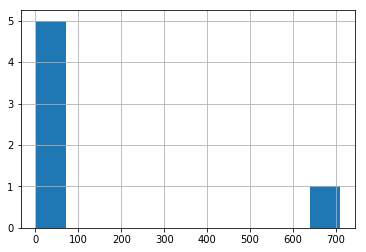

=========================HCICG01=========================
1.323077130965904 238.21666666666667 0.0
under 2 minutes delay count: 6073
under 5 minutes delay count: 69
under 30 minutes delay count: 5
under 60 minutes delay count: 12
under 120 minutes delay count: 5
under 180 minutes delay count: 1
under 360 minutes delay count: 2
over 360 minutes delay count: 2 
[6073, 6142, 6147, 6159, 6164, 6165, 6167] / normal status rate: 98.47575806713151 %


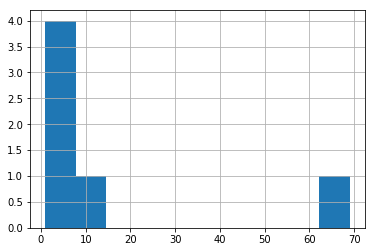

=========================HCICG01=========================
1.6093603675236567 538.1666666666666 0.0
under 2 minutes delay count: 3726
under 5 minutes delay count: 37
under 30 minutes delay count: 3
under 60 minutes delay count: 0
under 120 minutes delay count: 2
under 180 minutes delay count: 0
under 360 minutes delay count: 4
over 360 minutes delay count: 4 
[3726, 3763, 3766, 3766, 3768, 3768, 3772] / normal status rate: 98.78048780487805 %


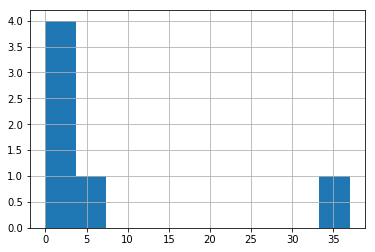

=========================HCICG01=========================
1.5550247175141492 1065.3333333333333 0.0
under 2 minutes delay count: 4712
under 5 minutes delay count: 2
under 30 minutes delay count: 0
under 60 minutes delay count: 2
under 120 minutes delay count: 0
under 180 minutes delay count: 0
under 360 minutes delay count: 1
over 360 minutes delay count: 1 
[4712, 4714, 4714, 4716, 4716, 4716, 4717] / normal status rate: 99.8940004239983 %


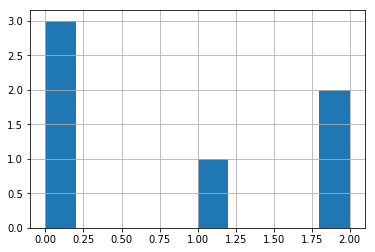

=========================HCICG01=========================
1.4234953064605271 336.93333333333334 0.0
under 2 minutes delay count: 1792
under 5 minutes delay count: 11
under 30 minutes delay count: 5
under 60 minutes delay count: 0
under 120 minutes delay count: 1
under 180 minutes delay count: 0
under 360 minutes delay count: 2
over 360 minutes delay count: 2 
[1792, 1803, 1808, 1808, 1809, 1809, 1811] / normal status rate: 98.95085588072888 %


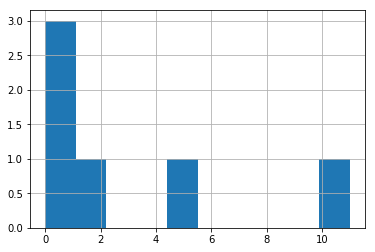

=========================HCICG01=========================
2.1970526575410148 297.3666666666667 0.0
under 2 minutes delay count: 2255
under 5 minutes delay count: 196
under 30 minutes delay count: 250
under 60 minutes delay count: 1
under 120 minutes delay count: 0
under 180 minutes delay count: 0
under 360 minutes delay count: 1
over 360 minutes delay count: 1 
[2255, 2451, 2701, 2702, 2702, 2702, 2703] / normal status rate: 83.42582315945246 %


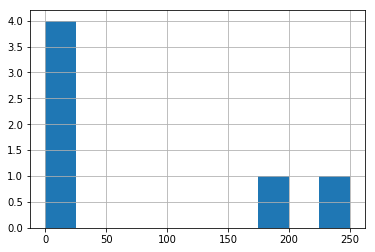

In [33]:
# delay count

delay_range = [2, 5, 30, 60, 120, 180, 360] #delay range in minutes

for key, data in dataset.items():
    print(f"========================={user}=========================")
    df = data['pos'].drop(data['pos'].index[0])    
    df['delay_minute'] = df['delay'].map(lambda x: x.seconds/60)
    print(df['delay_minute'].mean(), df['delay_minute'].max(), df['delay_minute'].min())    
    count_bucket = []
    for r in delay_range:
        count_bucket.append(len(df[df['delay_minute'] < r].index))
        if len(count_bucket) == 1:
            print(f"under {r} minutes delay count: {count_bucket[-1]}")
        else:
            print(f"under {r} minutes delay count: {count_bucket[-1] - count_bucket[-2]}")
    print(f"over {delay_range[-1]} minutes delay count: {count_bucket[-1] - count_bucket[-2]} ")
    print(f"{count_bucket} / normal status rate: {count_bucket[0] / count_bucket[-1] * 100} %")
    
    # show count hist except normal location data (< 2 mim)
    s = pd.Series(count_bucket)
    s = s.diff()        
    s = s.drop(s.index[0])    
    s.hist()
    plt.show()

<p>It seems that most of data were sent properly. (< 2 min) <br>
    There are few the 30 min gaps, becuase of 20 min test of DBLAB0101. So, it is intentional.<br>
    Let's see the other big gaps in detail.
    </p>

In [77]:
# when do we have big gaps?

def pick_gaps(df, r_min, r_max):
    gaps = {
        'min': r_min,
        'max': r_max,
    }
    #print(f"Culling {r_min} - {r_max} min")    
    df.drop(df.index[0], inplace=True)
    df.reset_index(drop=True, inplace=True)    
    df['delay_minute'] = df['delay'].map(lambda x: x.seconds/60)
    
    #culling gaps
    gaps['list'] = list(df[df['delay_minute'].between(r_min, r_max)].index )
    return gaps

In [78]:
#culling rows before and after gaps
def cull_gap_surroundings(df, r_min, r_max, around=2):            
    for center in gaps.index:
        print(f"{df.loc[center]['delay_minute']} min gap in {center}")
        print(df[center - around : center + around + 1])         
        

In [80]:
for key, data in dataset.items():
    for i, r in enumerate(reversed(delay_range[:-1])):                
        pos = data['pos']
        data['gaps'] = pick_gaps(pos.drop(pos.index[0]), r, delay_range[-(i+1)])

In [82]:
data_it = iter(dataset)

In [83]:
user = next(data_it)

In [84]:
dataset[user]

{'pos':           name      id  deviceid              servertime          devicetime  \
 15181  HCICG01  301567        54 2019-01-24 16:35:26.659 2019-01-17 18:26:46   
 15182  HCICG01  301568        54 2019-01-24 16:35:26.735 2019-01-17 18:27:48   
 15183  HCICG01  301569        54 2019-01-24 16:35:26.829 2019-01-17 18:28:55   
 15184  HCICG01  301570        54 2019-01-24 16:35:26.856 2019-01-17 18:31:01   
 15185  HCICG01  301571        54 2019-01-24 16:35:26.882 2019-01-17 18:32:05   
 15186  HCICG01  301572        54 2019-01-24 16:35:26.909 2019-01-17 18:33:45   
 15187  HCICG01  301573        54 2019-01-24 16:35:26.935 2019-01-17 18:35:13   
 15188  HCICG01  301574        54 2019-01-24 16:35:26.960 2019-01-17 18:36:13   
 15189  HCICG01  301575        54 2019-01-24 16:35:26.989 2019-01-17 18:37:14   
 15190  HCICG01  301576        54 2019-01-24 16:35:27.018 2019-01-17 18:39:17   
 15191  HCICG01  301577        54 2019-01-24 16:35:27.056 2019-01-17 18:41:16   
 15192  HCICG01  3015

In [ ]:
# day iteration test
start_date, end_date = period['DBLAB0103']['start'], period['DBLAB0103']['end']
print(start_date, end_date)
days = []
for single_date in daterange(start_date, end_date):
    days.append(single_date.replace(hour=0, minute=0, second=0))
print(days)

In [ ]:
# delay mean by days
for user in users['name']:
    print(f"========================={user}=========================")
    for single_date in daterange(period[user]['start'], period[user]['end']):
        today = single_date.replace(hour=0, minute=0, second=0)
        tomorrow  = today + timedelta(days=1)
        print(f"DAY {today} - {tomorrow}")        
        
        df = pos[user]        
        pos_by_day = df[(df['devicetime'] >= today) & (df['devicetime'] < tomorrow)]
        print(pos_by_day[view_time].head(5))
        if pos_by_day.shape[0] == 0:
            continue
        
        print("Delays")        
        print("mean", pos_by_day['delay'].mean())   
        print("max", pos_by_day['delay'].max(), pos_by_day['delay'].idxmax(), pos_by_day.loc[[pos_by_day['delay'].idxmax()]])   
        print("min", pos_by_day['delay'].min())   
        print()
